# FinBert
```
Env: python 3.11.5 (conda sentiment)
transformer: pip install transformers[sentencepiece]
```

## 1. Import / Data

### 1.1 Import

In [3]:
import matplotlib.pyplot as plt
import yfinance as yf
import pickle, torch, re, gc, sys, datetime, psutil
import pandas as pd
import numpy as np
import transformers
import warnings
from googletrans import Translator
from scipy.stats.mstats import winsorize
from googletrans import  Translator
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, pipeline, AdamW,\
    get_linear_schedule_with_warmup, BertConfig
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from torch.nn.functional import softmax
warnings.filterwarnings("ignore")
transformers.__version__

'4.27.0.dev0'

### 1.2 Data Preprocess

##### 1.2.0 Functions

- device usage
- translation

In [4]:
# check device usage
def get_cpu_usage():
    return psutil.cpu_percent(interval=1)

def get_ram_usage():
    return psutil.virtual_memory().percent

# translate
def trans(text_list):
    translator = Translator(service_urls=[
      'translate.google.com',
      'translate.google.co.kr',
    ])
    eng_texts = [translator.translate(i, dest='en').text for i in text_list]
    return eng_texts

##### 1.2.1 Preprocess

In [5]:
# price data
stock = "2409.TW"
prc = yf.download(stock)
prc["return"] = (prc["Adj Close"].shift(-1) - prc["Adj Close"])/prc["Adj Close"]
prc = prc.reset_index().rename(columns={"Date":"time"})
prc.time = prc.time.dt.date

[*********************100%%**********************]  1 of 1 completed


In [11]:
# read text data and transform time
# here no missing data
def get_text_data(filename):
    with open(f'news/texts/{filename}.pk', 'rb') as f:
        data = pickle.load(f)
    data.drop("index", axis=1, inplace=True)
    data.time = data.time.apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M')).dt.date
    data.drop(["url"], axis=1, inplace=True)
    return data

# texts data: 2409 => anue_2409_20231208to20211224
# texts data: 友達 => anue_友達_20231215to20221227
# texts data: 面板 => anue_面板_20231216to20230412
data_1 = get_text_data("anue_2409_20231208to20211224")
data_2 = get_text_data("anue_友達_20231215to20221227")
data_3 = get_text_data("anue_面板_20231216to20230412")

# to dict
data_1 = data_1.set_index(["time"])["content"].to_dict()
data_2 = data_2.set_index(["time"])["content"].to_dict()
data_3 = data_3.set_index(["time"])["content"].to_dict()

In [12]:
times = set(list(data_2.keys()) + list(data_3.keys())) # list(data_1.keys())
data = dict()

# combine data from different datas
for time in times:
    content = ""
    """
    if time in data_1.keys():
        content += data_1[time]
    """
    if time in data_2.keys():
        content += data_2[time]
    if time in data_3.keys():
        content += data_3[time]
    data[time] = [content]

# data dictionary to dataframe
data = pd.DataFrame.\
        from_dict(data, orient="index", columns=["content"]).\
        reset_index().\
        rename(columns={"index": "time"})
data.head(3)

,time,content
0,2023-06-14,三大法人合計在集中市場買超 109.85 億元，其中，外資買超 61.09 億元，為連 4 ...
1,2023-08-10,關注台股盤前要聞重點。台塑集團旗下新智能將斥資 3 億元，入股鋰電池儲能系統大廠儲盈科技，未...
2,2023-05-25,觀察三大法人今天籌碼動向，外資回頭買超 217.21 億元；投信買超 24.86 億元；自營...


In [13]:
# make time in data cosistent of price datas' time
def process_time(prc, data):
    # update time in text data to match time in price data
    for index, (time, content) in data.iterrows():
        while time not in list(prc.time):
            time += datetime.timedelta(days=1)
        data.loc[index, 'time'] = time

    # check if all time in text data in price data
    for time in data.time:
        if time not in list(prc.time):
            print("error")
    
    return data
# combine the texts in the same date
def text_concat_within_same_date(data):
    concat_text = {}
    # concatenate news in the same date
    for index, (time, content) in data.iterrows():
        if index == 0:
            new_content = content
        else:
            if time == time_last:
                new_content += ("\n" + content)
            else:
                new_content = content
        
        concat_text[time] = new_content
        time_last = time 

    # dict to dataframe
    concat_text = pd.DataFrame(list(concat_text.items()), columns=["time", "content"])
    # check if time got duplicated
    print(f"duplicated time: {concat_text.time.duplicated().sum()}")
    return concat_text
# merge text and price data
def merge_prc_text(prc, data):
    valid_time = pd.merge(prc, data, on='time', how='left').\
                            fillna(method = "ffill").\
                            dropna()["time"]
    prc_text = pd.merge(prc, data, on='time', how='left')
    prc_text = prc_text[prc_text.time.isin(list(valid_time))]
    return prc_text

data = process_time(prc, data)
data = text_concat_within_same_date(data)
prc_text = merge_prc_text(prc, data).rename(columns={'content': 'stock'})

duplicated time: 0


In [14]:
prc_text.reset_index(inplace=True)

##### 1.2.2 Data time range 

In [ ]:
from_date = pd.to_datetime("2022-07-01").tz_localize("Asia/taipei")
end_date = pd.to_datetime("2023-04-30").tz_localize("Asia/taipei")
val_from_date = pd.to_datetime("2023-05-01").tz_localize("Asia/taipei")
val_end_date = pd.to_datetime("2023-08-10").tz_localize("Asia/taipei")

time_val = pd.Timestamp(2023, 2, 1)
time_test = pd.Timestamp(2023, 5, 1)
data_train = data_all[data_all["time"] <= time_val]
data_val = data_all[(data_all["time"] >= time_val) & (data_all["time"] <= time_test)]
data_test = data_all[data_all["time"] >= time_test]
return_train = return_all[return_all["time"] <= time_val]
return_val = return_all[(return_all["time"] >= time_val) & (return_all["time"] <= time_test)]
return_test = return_all[return_all["time"] <= time_test]

# get data shortened
path = f"{sys.path[-1]}text_shortened/shortened_{media}_{keyword}.pickle"
data_all = pickle_load(path)

# merge_data is data merge with text data and return data
batch_size = 5
data_train, merge_train = get_dataloader(data_train, return_all, batch_size = batch_size)
data_val, merge_val = get_dataloader(data_val, return_all, batch_size = 1)
data_test, merge_test = get_dataloader(data_test, return_all, batch_size = 1)

##### 1.2.2 Dataloader
- Use list to store dataset for each date

In [ ]:
'def get_loader():'
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
texts_name = 'stock'
batch = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

time_list = []
datasets_list = []
time_no_text_list = []
for index, (time, returns, content) in prc_text[["time", "return", texts_name]].iterrows():
    try:
        content = content.split("\n")        
        content = trans(content)
        inputs = tokenizer(list(content), return_tensors="pt", padding=True)
        input_ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        attention_mask = inputs["attention_mask"]
        time_list.append(time)
        datasets = TensorDataset(torch.tensor(returns).to(device),
                                 torch.tensor(input_ids).to(device),
                                 torch.tensor(token_type_ids).to(device),
                                 torch.tensor(attention_mask).to(device))
        datasets_list.append(datasets)
    except:
        print(type(content))
        print(content)
        time_no_text_list.append(time)
    print("="*70)
    print(content)
    print(index)
    if index >= 3:
        break

# Create the DataLoader for our training set.
sampler = SequentialSampler(data)
dataloader = DataLoader(data, sampler=sampler, batch_size=batch)

In [26]:
# Create the DataLoader for our training set.
sampler = SequentialSampler(data)
dataloader = DataLoader(data, sampler=sampler, batch_size=batch)

In [27]:
for k, (i, s) in dataloader:
    print(i)
    break

KeyError: 0

### 1.3 Text Len Check
```no need to run```

Check if text length too long for finber

In [9]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

In [11]:
prc_text = prc_text
scores = dict()
score = 0

# check the tokens >= 512?
for index, (time, content) in prc_text[["time", "content"]].iterrows():
    if str(content) == "nan":
        scores[time] = score
    else:
        try:
            content = content.split("\n")
            inputs = tokenizer(content, return_tensors="pt", padding=True)
            outputs = finbert(**inputs)[0]
        except:
            print("text too long")
            break


text too long


## 2. PRETRAINED MODEL
- [Transformer](https://huggingface.co/docs/transformers/index)
- [Tokeniser Doc](https://huggingface.co/docs/transformers/main_classes/tokenizer)
- [Model Lists Transformers](https://huggingface.co/docs/transformers/main_classes/model)
- Long Document Solution
    - Chunks
    - Longformer - need fine tune\
        Wanrings
        ```
        Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']

        You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
        ```
    

In [7]:
# Model
model_name = 'yiyanghkust/finbert-tone'
revision = "main"
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
summarise = pipeline("summarization")

# Load pre-trained Longformer model and tokenizer
model_name = "allenai/longformer-base-4096"  # You can choose a different Longformer model
longformer = LongformerForSequenceClassification.from_pretrained(model_name)
'tokenizer_long = LongformerTokenizer.from_pretrained(model_name)'

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'tokenizer_long = LongformerTokenizer.from_pretrained(model_name)'

### 2.1 Example for FinBert / Summarization / Longformer
```here for try the models. no need to run here when Scoring the news```

##### 2.1.1 Finbert

In [ ]:
# Finbert
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

sentences = ["there is a shortage of capital, and we need extra financing",
             "growth is strong and we have plenty of liquidity",
             "there are doubts about our finances",
             "profits are flat",
             "the stock price could rise a lot",  # Weird result
             "the forecast of the company is not good"]

inputs = tokenizer(sentences, return_tensors="pt", padding=True)
outputs = finbert(**inputs)[0]

labels = {0:'neutral', 1:'positive',2:'negative'}
for idx, sent in enumerate(sentences):
    print(sent, '----', labels[np.argmax(outputs.detach().numpy()[idx])])

##### 2.1.2 FinBert Scores


output = [nuetral, positive, negative]

In [28]:
# FinBert Scores
# [nuetral, positive, negative]
text = ["good price day",
        "market share rise so fast"
        "market is experiencing unprecedented rise because of the quantitative ease",
        "market is getting better",
        "better to short the market",
        "revenue decrease a lot due to pandemic"]
inputs = tokenizer(text, return_tensors="pt", padding=True)
outputs = finbert(**inputs)[0]
outputs

inputs = tokenizer(text, return_tensors="pt", padding=True, return_length =True)
print(inputs["input_ids"].shape[1])
print(inputs["length"])
outputs = finbert(**inputs)[0]

##### 2.1.3 Try Summarise: Long Text (max length 1024)

In [ ]:
# Try Summarise: Long Text (max length 1024)
text = [
"""
Artificial Intelligence (AI) is no longer a distant concept confined to the realms of science fiction. It has become an integral part of our daily lives, reshaping the way we live, work, and interact with the world. As AI technologies continue to advance at an unprecedented pace, the impact on society is profound and multifaceted.
In healthcare, AI is revolutionizing diagnostics and treatment. Machine learning algorithms analyze medical data with incredible speed and accuracy, aiding doctors in identifying diseases and recommending personalized treatment plans. This not only improves patient outcomes but also opens new possibilities for medical research and drug discovery.
The business landscape is undergoing a seismic shift with the integration of AI. From automating routine tasks to enhancing data analytics, businesses are leveraging AI to streamline operations and gain a competitive edge. Virtual assistants powered by AI are transforming customer service, providing instant responses and improving overall user satisfaction.
Education is experiencing a paradigm shift with AI-driven personalized learning. Adaptive learning platforms use algorithms to tailor educational content to individual students, addressing their unique learning styles and pacing. This approach not only enhances student engagement but also fosters a deeper understanding of the material.
However, the rapid integration of AI into various sectors raises significant challenges. Job displacement due to automation is a growing concern, prompting a reevaluation of workforce skills and education. Striking a balance between the benefits of automation and the potential impact on employment is a critical task for policymakers.
Ethical considerations surrounding AI implementation cannot be ignored. Biases in AI algorithms, often reflective of historical data, can perpetuate discrimination. Ensuring fairness, transparency, and accountability in AI decision-making processes is paramount to building trust and mitigating unintended consequences.
The future of AI in society hinges on responsible development and ethical use. As the technology evolves, collaboration between researchers, businesses, and policymakers is crucial to establish guidelines that prioritize societal well-being. Transparency in AI systems, accountability for their outcomes, and proactive measures to address ethical concerns are imperative.
Looking ahead, AI holds the promise of further advancements that could reshape our world. The journey involves navigating through challenges, embracing ethical practices, and fostering a collective understanding of the transformative power of artificial intelligence. In doing so, society can harness the full potential of AI, ensuring it becomes a force for positive change, innovation, and sustainable progress.
""",
"""
The global shift towards renewable energy sources has become a focal point in addressing climate change and ensuring a sustainable future for generations to come. As traditional fossil fuels continue to contribute to environmental degradation, the exploration and adoption of renewable energy technologies have gained momentum, offering a cleaner and more sustainable alternative.
Solar energy stands out as one of the most promising renewable resources. Harnessing the power of the sun, solar panels convert sunlight into electricity, providing a clean and abundant source of energy. The declining costs of solar technology and increased efficiency have made it a viable option for widespread adoption, both in residential and industrial settings.
Wind energy is another key player in the renewable energy landscape. Wind turbines, strategically placed in windy locations, generate electricity as the force of the wind turns their blades. Advances in turbine technology and the establishment of wind farms contribute significantly to the global renewable energy capacity. The scalability of wind energy projects, from small-scale applications to large-scale power plants, makes it a versatile and scalable solution.
Hydropower has been a traditional source of renewable energy, with dams and water turbines generating electricity from the kinetic energy of flowing water. While large-scale hydroelectric projects have been in use for decades, innovations in small-scale hydropower systems are providing sustainable energy solutions for remote areas and communities.
Bioenergy, derived from organic materials such as agricultural residues and organic waste, offers a renewable alternative to traditional fossil fuels. Biomass can be converted into biofuels, such as biodiesel and bioethanol, providing cleaner options for transportation and reducing reliance on non-renewable energy sources.
Geothermal energy taps into the Earth's internal heat, utilizing steam and hot water reservoirs beneath the Earth's surface to generate electricity. Geothermal power plants have a smaller environmental footprint compared to traditional power plants, making them a sustainable option for both electricity generation and direct heating applications.
While the transition to renewable energy sources brings numerous environmental and economic benefits, challenges persist. The intermittency and variability of renewable sources, such as solar and wind, pose challenges for energy grid stability. Advances in energy storage technologies, such as large-scale batteries, are crucial for storing excess energy during peak production times for use during periods of low renewable energy generation.
Moreover, the need for infrastructure investment and policy support to accelerate the adoption of renewable energy cannot be overstated. Governments, businesses, and communities must collaborate to create a conducive environment for renewable energy projects, including incentives, regulations, and research funding.
The economic advantages of investing in renewable energy are becoming increasingly apparent. The renewable energy sector has become a driver of job creation, innovation, and economic growth. As the costs of renewable technologies continue to decrease, the economic viability of these projects becomes more attractive, creating a positive feedback loop for further adoption.
In conclusion, the transition to renewable energy is a pivotal step towards a sustainable and greener future. The ongoing innovations in solar, wind, hydropower, bioenergy, and geothermal technologies showcase the diverse and evolving nature of renewable resources. By overcoming challenges through technological advancements and collaborative efforts, society can pave the way for a cleaner, more sustainable energy landscape. The adoption of renewable energy is not merely an option; it is a necessity for building a resilient and environmentally conscious world.
"""]

# summary model 1
# classifier = pipeline('sentiment-analysis')
# classifier(text_to_summarize)

# summary model 2
s = summarise(text, 
                max_length=300, 
                min_length=100, 
                length_penalty=2.0, 
                num_beams=4)


##### 2.1.5 Try Sentiment Classification: Long Text, Longformer (max length 4096?)


warning message:
```
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).

Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

In [94]:
# Try Sentiment Classification: Long Text, Longformer (max length 4096?)
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from torch.nn.functional import softmax

# Load pre-trained Longformer model and tokenizer
model_name = "allenai/longformer-base-4096"  # You can choose a different Longformer model
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(model_name)

# Text
text = """Artificial Intelligence (AI) has become a ubiquitous presence in the modern world, influencing diverse facets of society ranging from business and healthcare to education and entertainment. As AI technologies continue to advance at a rapid pace, their impact on our lives becomes increasingly profound, offering both opportunities and challenges that demand careful consideration.
At its core, AI refers to the development of computer systems capable of performing tasks that typically require human intelligence. These tasks encompass a wide array of activities, including problem-solving, speech recognition, learning, and decision-making. AI systems can be broadly categorized into narrow AI, designed for specific tasks, and general AI, which possesses the ability to perform any intellectual task a human can.
One notable advantage of AI lies in its capacity to automate repetitive and mundane tasks, significantly enhancing efficiency. Industries such as manufacturing, logistics, and customer service have experienced substantial improvements through the adoption of AI-driven automation. This not only streamlines operations but also allows human workers to focus on more creative and complex aspects of their jobs.
The healthcare sector is undergoing a transformative shift due to AI advancements. Machine learning algorithms are revolutionizing diagnostics, drug discovery, and patient care. These technologies analyze vast datasets to identify patterns, enabling early disease detection and more effective treatments. Surgical robots equipped with AI enhance the precision and success rates of medical procedures.
In the realm of technology and entertainment, AI plays a pivotal role in shaping personalized user experiences. Streaming platforms utilize AI algorithms to recommend content based on users' preferences, while virtual assistants like Siri and Alexa leverage natural language processing to understand and respond to user commands.
AI is not confined to individual sectors; it is also contributing to environmental sustainability. Applications of AI, such as smart grids optimizing energy consumption and predicting natural disasters, promote eco-friendly practices. The integration of AI technologies in addressing environmental challenges reflects the potential for positive impact on a global scale.
However, alongside the promises of AI come concerns and challenges that society must grapple with. Job displacement is a prevalent concern, as the automation facilitated by AI may lead to the elimination of certain jobs, particularly those involving routine tasks. To address this, societies need to adapt by providing education and training opportunities for individuals to acquire skills aligned with the evolving job market.
Moreover, the issue of bias in AI systems has raised ethical concerns. AI systems are only as unbiased as the data they are trained on. This becomes especially problematic in decision-making processes such as hiring, lending, and criminal justice. Efforts are underway to develop fair and transparent AI systems that consider diverse perspectives and avoid reinforcing existing biases.
In conclusion, the impact of AI on society is profound and multifaceted. While it brings about positive transformations in various sectors, careful consideration of ethical, social, and economic implications is necessary. Society must actively engage in shaping the development and deployment of AI to ensure it aligns with human values and promotes the well-being of all.
"""
text += """
AI has not only transformed specific industries but has also become an integral part of everyday life. Virtual assistants like Siri, Alexa, and Google Assistant utilize AI to understand and respond to user commands, enhancing the convenience of human-computer interactions. AI-driven recommendation systems on streaming platforms and e-commerce websites personalize user experiences, influencing the content we consume and the products we discover.
The development of autonomous vehicles represents another frontier where AI is making significant strides. Machine learning algorithms enable these vehicles to perceive their surroundings, make real-time decisions, and navigate complex environments. As AI continues to advance, the prospect of a future with widespread autonomous transportation becomes increasingly plausible.
The creative domain is not immune to the influence of AI. Generative models, such as OpenAI's GPT-3, demonstrate the ability to produce human-like text based on prompts. AI-generated art, music, and literature challenge traditional notions of creativity and pose questions about the intersection of AI and human expression.
However, alongside these advancements, ethical considerations persist. The use of AI in surveillance, for instance, raises concerns about privacy and civil liberties. Facial recognition technology, when misused, can infringe on individual rights, leading to a delicate balance between security and personal freedoms.
AI's global impact also raises questions about accessibility and the potential for exacerbating existing inequalities. Developing nations may face challenges in adopting and benefiting from AI technologies, creating a digital divide. Addressing these disparities requires a concerted effort to ensure that the benefits of AI are shared equitably across diverse communities.
Looking forward, the evolution of AI holds promise for addressing some of humanity's most pressing challenges. AI technologies contribute to scientific research, aiding in the analysis of complex datasets and accelerating discoveries in fields such as medicine and climate science. The ability of AI to process vast amounts of information quickly makes it a valuable tool in tackling issues that require sophisticated computational analysis.
The future relationship between humans and AI will likely be defined by collaboration. AI technologies can augment human capabilities, leading to enhanced problem-solving and innovation. As AI becomes more integrated into society, fostering interdisciplinary collaborations and ensuring ethical guidelines will be crucial for realizing the full potential of this transformative technology.
In conclusion, the journey of AI from its inception to its current state is marked by rapid advancements and transformative impacts. From reshaping industries to influencing daily interactions, AI has become an integral part of the modern landscape. As we navigate the complexities of AI's influence, ethical considerations, inclusivity, and responsible development practices will play pivotal roles in shaping a future where AI contributes positively to humanity.
"""
text += """
As AI technologies continue to evolve, the integration of AI into robotics is unlocking new possibilities. Robotics, enhanced by AI capabilities, is transforming industries like manufacturing, logistics, and even healthcare. Collaborative robots, or cobots, equipped with AI-powered vision systems can work alongside humans, increasing efficiency and safety in various work environments.
The intersection of AI and quantum computing presents another frontier of exploration. Quantum AI holds the potential to solve complex problems that are currently beyond the reach of classical computers. This convergence may lead to breakthroughs in fields such as cryptography, optimization, and material science, opening new avenues for innovation.
The democratization of AI tools and technologies is also a noteworthy trend. Open-source AI frameworks and platforms allow developers worldwide to access and contribute to cutting-edge AI research. This collaborative approach accelerates innovation and fosters a diverse community of practitioners working on AI solutions for a wide range of applications.
AI's impact on creativity extends beyond text generation and includes the generation of visual and auditory content. AI-generated art, music, and virtual environments challenge traditional notions of human creativity. The exploration of AI as a creative tool raises philosophical questions about the nature of creativity and the role of machines in artistic expression.
The ethical considerations surrounding AI are becoming increasingly complex. As AI systems become more autonomous and capable of independent decision-making, questions of accountability and transparency become paramount. Ensuring that AI systems align with human values and ethical standards requires ongoing dialogue and interdisciplinary collaboration.
Despite the transformative potential of AI, there are concerns about the concentration of power in the hands of a few tech giants. The responsible development and deployment of AI necessitate considerations of fairness, accountability, and avoiding the undue concentration of influence. Policymakers, technologists, and society at large play critical roles in shaping a future where AI benefits everyone.
Looking ahead, the concept of explainable AI (XAI) is gaining prominence. As AI systems become more intricate, understanding the decision-making processes becomes essential, especially in critical applications such as healthcare and finance. Explainability enhances trust in AI systems and facilitates their responsible use.
In conclusion, the journey of AI is an ongoing exploration of innovation, challenges, and ethical considerations. From its roots in rule-based systems to the current era of machine learning and beyond, AI continues to reshape the way we live and work. The future promises even more profound transformations, and navigating this evolving landscape requires a commitment to ethical principles, inclusivity, and responsible development.
"""
text_2 =  """The future of energy is undergoing a transformative shift towards sustainability and environmental consciousness. As the global community grapples with the consequences of climate change, the imperative to transition to renewable energy sources has never been more apparent. In this comprehensive exploration, we will delve into the current state of renewable energy, emerging technologies, and the potential impact on our planet.
Renewable energy sources, including solar, wind, hydro, geothermal, and biomass, have gained significant traction in recent years. Solar power, in particular, has witnessed tremendous growth, with advancements in photovoltaic technology making solar panels more efficient and cost-effective. Wind turbines, both onshore and offshore, contribute significantly to electricity generation in various regions.
Hydropower remains a major player in the renewable energy sector, harnessing the power of flowing water to generate electricity. Geothermal energy taps into the Earth's internal heat, while biomass utilizes organic materials for energy production. The collective efforts in diversifying renewable energy portfolios contribute to a more resilient and sustainable energy landscape.
Emerging technologies are poised to further revolutionize the renewable energy sector. Advanced energy storage solutions, such as high-capacity batteries and innovative grid systems, address the intermittent nature of renewable sources, ensuring a stable and reliable power supply. Smart grid technologies enable more efficient energy distribution and consumption, empowering consumers to actively participate in managing their energy use.
The concept of floating solar farms on water bodies presents a novel approach to maximizing solar power generation, especially in regions with limited land availability. Additionally, the development of next-generation solar cells, such as perovskite solar cells, holds the promise of higher efficiency and lower production costs.
Offshore wind farms represent a frontier of innovation in wind energy. By harnessing powerful offshore winds, these projects have the potential to significantly increase electricity generation. Tidal and wave energy technologies are also under exploration, tapping into the vast energy potential of the world's oceans.
The shift towards renewable energy has far-reaching implications for global sustainability and environmental health. By reducing reliance on fossil fuels, renewable energy mitigates the impact of greenhouse gas emissions, contributing to the fight against climate change. Improved air and water quality, along with a decrease in harmful pollutants, lead to healthier ecosystems and communities.
Renewable energy also plays a crucial role in enhancing energy access and security. Off-grid solutions, powered by solar panels and decentralized energy systems, bring electricity to remote and underserved areas. This not only improves the quality of life for communities but also fosters economic development and resilience.
Despite the remarkable progress in renewable energy, challenges persist. The intermittency of solar and wind power requires effective energy storage solutions to ensure a consistent power supply. The need for widespread infrastructure upgrades and the integration of renewable sources into existing grids pose logistical challenges.
The transition from traditional energy sources to renewables necessitates careful consideration of the economic and social impacts on communities heavily reliant on the fossil fuel industry. Job transitions, retraining programs, and inclusive policies are vital components of a just and equitable energy transition.
In conclusion, the future of renewable energy holds immense promise for a sustainable and resilient global energy landscape. Technological innovations, coupled with a commitment to addressing challenges and ensuring inclusivity, are key to realizing this vision. As we collectively strive for a cleaner and more sustainable future, the evolution of renewable energy will continue to shape the way we power our world.
"""
text_2 += """The evolution of renewable energy is intricately tied to the global commitment to combat climate change. International agreements and initiatives, such as the Paris Agreement, underscore the urgency of transitioning to low-carbon energy systems. The collaborative efforts of nations, businesses, and communities are crucial in achieving the ambitious targets set for reducing carbon emissions and limiting global temperature rise.
The role of governments in shaping energy policies and providing incentives for renewable energy adoption cannot be overstated. Financial support, subsidies, and regulatory frameworks play pivotal roles in encouraging investments in renewable infrastructure. Policies that prioritize sustainability and environmental responsibility contribute to creating an enabling environment for renewable energy projects to thrive.
Community engagement and awareness are integral components of the renewable energy transition. Educating the public about the benefits of renewable energy, dispelling myths, and fostering a sense of collective responsibility empower individuals to make sustainable choices in their energy consumption. Grassroots movements advocating for renewable energy initiatives further amplify the impact of these transitions.
The economic benefits of investing in renewable energy are becoming increasingly evident. The renewable energy sector is a significant source of job creation, spanning a range of roles from research and development to installation and maintenance. As the sector expands, it stimulates economic growth, fosters innovation, and positions countries at the forefront of the global clean energy transition.
Innovative financing models, such as green bonds and impact investing, are contributing to the acceleration of renewable energy projects. These financial mechanisms attract investments with a focus on both environmental and social returns. The diversification of funding sources ensures the scalability and sustainability of renewable energy initiatives.
Looking ahead, the concept of energy decentralization holds promise for transforming how we generate and consume energy. Decentralized energy systems, including microgrids and distributed renewable sources, offer resilience against disruptions and empower communities to have greater control over their energy destinies. The democratization of energy production shifts the narrative from centralized power structures to a more inclusive and community-driven energy landscape.
In conclusion, the future of renewable energy is dynamic and promising, driven by technological advancements, policy interventions, and societal shifts towards sustainability. As the world collectively pursues a greener and more sustainable energy future, the trajectory of renewable energy will continue to shape the way we power our societies, mitigate climate change, and build a more resilient and equitable world.
"""
text_2 += """The integration of renewable energy into smart cities is a key aspect of sustainable urban development. Smart grids, combined with renewable energy sources, enhance energy efficiency, reduce emissions, and enable cities to become more resilient to the challenges of climate change. These initiatives also promote the adoption of electric vehicles and contribute to the overall reduction of carbon footprints in urban environments.
The electrification of transportation represents a significant frontier in the renewable energy landscape. Electric vehicles (EVs) powered by renewable energy sources offer a cleaner and more sustainable alternative to traditional fossil fuel vehicles. The development of EV infrastructure, including charging stations and battery technologies, is a crucial component in accelerating the transition to a sustainable transportation system.
The concept of circular economies aligns with the principles of renewable energy. By emphasizing the reuse, recycling, and repurposing of materials, circular economies minimize waste and environmental impact. The integration of renewable energy technologies into circular economic models further enhances the sustainability of resource use and contributes to the long-term health of ecosystems.
The global interconnectedness of energy systems highlights the importance of international collaboration in advancing renewable energy goals. Cross-border initiatives for energy sharing, joint research and development projects, and the establishment of global standards contribute to a more cohesive and effective approach to addressing energy challenges on a planetary scale.
The exploration of innovative materials and designs in renewable energy technologies continues to drive efficiency improvements. From advanced materials in solar panels to novel turbine designs in wind energy, ongoing research and development initiatives push the boundaries of what is possible. These innovations hold the potential to further reduce the cost of renewable energy production and increase its accessibility globally.
The social dimensions of renewable energy adoption are crucial for ensuring an inclusive and just transition. Engaging local communities in decision-making processes, addressing potential social inequalities, and recognizing the cultural context of renewable energy projects are vital components of fostering acceptance and support. The democratization of energy production includes empowering communities to actively participate in and benefit from renewable energy initiatives.
In conclusion, the future of renewable energy extends beyond technological advancements to encompass broader societal, economic, and environmental considerations. The integration of renewable energy into various facets of our lives, from transportation to urban planning, reflects a holistic approach to sustainability. As we navigate this transformative journey, the collective commitment to renewable energy is key to building a resilient, equitable, and environmentally conscious future.
"""
text = [text, text_2]

# Tokenize and process the input
inputs = tokenizer(text, return_tensors="pt", padding=True)
input_ids = inputs["input_ids"]
print(inputs["input_ids"].shape[1])

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Extract predicted probabilities and sentiment label
probabilities = softmax(torch.sum(outputs.logits, dim = 0))
predicted_class = torch.argmax(probabilities).item()

# Map class index to sentiment label (e.g., 0 for negative, 1 for positive)
sentiment_labels = ["Negative", "Positive"]
predicted_sentiment = sentiment_labels[predicted_class]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1635


In [81]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification
from torch.nn.functional import softmax

# Load pre-trained Longformer model and tokenizer
model_name = "allenai/longformer-base-4096"  # You can choose a different Longformer model
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(model_name)

pytorch_model.bin: 100%|██████████| 597M/597M [26:09<00:00, 380kB/s]  
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.2 Get Scores for Stock Data


In [ ]:
# scores
scores = dict()
score_date = torch.tensor([0., 0., 0.])
for index, (time, returns, content) in prc_text[["time", "return", "stock"]].iterrows():
    # gc.collect()
    print("="*70)
    print(f"Sentiment for {time}")
    print(f"CPU Usage: {get_cpu_usage()}%")
    print(f"RAM Usage: {get_ram_usage()}%")

    # if no content set the date's score to be last date's score
    if str(content) == "nan":
        print(f"no text today")
        score_date = None
        long = None
        scores[time] = [returns, score_date]

    # if have content, get the score from model        
    else:
        # seperate content for different news
        content = content.split("\n")        
        content = trans(content)
        try:
            long = False
            # if the content short enough, get the score directly
            inputs = tokenizer(content, return_tensors="pt", padding=True) 
            print(inputs["input_ids"].shape)
            outputs = finbert(**inputs)[0][:, 1:]
        # if the content is too long, summarise it
        except:
            print("Required for Longformer")
            long = True

            inputs = tokenizer(content, return_tensors="pt", padding=True)
            outputs = longformer(**inputs).logits[:, [1, 0]]
        
        score_date = softmax(torch.sum(outputs, dim=0))
        scores[time] = [returns, score_date, long]
    print(f'scroes: {score_date}')


In [ ]:
score_history = []
return_history = []
time_history = []
for k, i in zip(list(scores.keys()), list(scores.values())):
    print(i[1])
    s = 0 if torch.argmax(i[1]) == 0 else (i[1][1] + (-1)*i[1][2])#.detach().numpy()
    score_history.append(s)
    return_history.append(i[0])
    time_history.append(k)

In [13]:
with open("/content/drive/MyDrive/sentiment/score_temp.pickle", "wb") as f:
    pickle.dump(scores_overall, f)

### 2.3 Backtest

In [14]:
# Final score
scores_overall
with open("/content/drive/MyDrive/sentiment/score_temp.pickle", "rb") as f:
    scores_overall = pickle.load(f)
labels = {0:'neutral', 1:'positive',2:'negative'}
returns = []
prediction = []
val_ret = datamerge_test[["time", "return"]][:scores_overall.shape[0]]
for idx, (time, ret) in val_ret.iterrows():
    # ----------------------------------
    # type I score
    prediction_scores = np.argmax(scores_overall.numpy()[idx]) + 1
    # type II score
    s = scores_overall.numpy()[idx]
    prediction_scores = s[0]*0 + s[1]*1 + s[2]*(-1)
    """print(s)"""
    # ----------------------------------
    returns.append(ret)
    prediction.append(prediction_scores)
val_prediction = val_ret
val_prediction["prediction"] = prediction
winsorization_percentage = 0.05
val_prediction["prediction"] = winsorize(val_prediction["prediction"],
                                         limits=(winsorization_percentage, winsorization_percentage))
val_prediction = val_prediction.iloc[::-1]
# val_prediction

In [ ]:
# scores values sum of lag n prediction scores
lag = 5
val_prediction[f"prediction_ma{lag}"] = val_prediction["prediction"]
for i in range(lag):
    val_prediction[f"prediction_lag{i}"] = val_prediction["prediction"].shift(-i)
    val_prediction[f"prediction_ma{lag}"] = val_prediction[f"prediction_ma{lag}"] + \
                                            (0.5**i)*val_prediction[f"prediction_lag{i}"]
val_prediction

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(val_prediction["prediction"])
plt.plot(val_prediction["return"]*2000)

In [31]:
# compute returns
buy = 0
count_buy = 0
count_sell = 0
sell = 0
neutral = 0
state = ""
scores = []
scores_mean = val_prediction["prediction"].mean()
scores_std = val_prediction["prediction"].std()
for index, (time, r_, pred) in val_prediction[["time", "return", f"prediction_ma{lag}"]].iterrows():
    scores.append(pred)
    scores_mean = np.mean(scores)
    if  pred >= scores_mean + scores_std:
        count_buy += 1
        if state != "buy":
            buy += (r_ - 0.004)
            state = "buy"
        else:
            buy += r_
    elif pred < scores_mean - scores_std:
        count_sell += 1
        if state != "sell":
            sell += (r_ - 0.004)
            state = "sell"
        else:
            sell += r_
    else:
        if state != "neu":
            neutral += (r_ - 0.004)
            state = "neu"
        else:
            neutral += r_
print(f"N positive: {count_buy}; N negative: {count_sell}")
print(f"buy with positive: {buy}")
# print(f"buy with predicted return between +(-)0.004: {neutral}")
print(f"buy with negative: {sell}")
print(f"buy all: {val_prediction['return'].sum()}")

N positive: 23; N negative: 18
buy with positive: 0.07269195648295759
buy with negative: -0.06632098541035134
buy all: 0.11328314749468767


# 3. FINETUNE
- Finbert
    - Finbert required length are met by adding a layer before finbert
- Longformer


### Data

In [ ]:
time_val = pd.Timestamp(2022, 12, 1)
time_test = pd.Timestamp(2023, 5, 1)
data_train = data_all[data_all["time"] <= time_val]
data_val = data_all[(data_all["time"] >= time_val) & (data_all["time"] <= time_test)]
data_test = data_all[data_all["time"] >= time_test]
data_test

### 3.2 Models

#####  3.2.1 

In [ ]:
# Hyper parameters for tuning finBert
config = {
    "epoch": 10,
    "lr": 0.001,
    "weight_decay": 0.001,
    "num_warmstep": 5000, # 10000
          }
batch_size = 5

### Two Models: Train, Val, and Backtest

##### === Model finetune ===

###### Backtest func

In [50]:
# backtest functions
def backtest(test_result):

    output, returns, loss = test_result
    labels = {0: "neu", 1:"pos", 2:"neg"}
    positive = 0
    negative = 0
    neutral = 0
    count_positive = 0
    count_negative = 0
    count_neutral = 0
    state = ""
    for (o_, r_) in zip(output, returns):
        if np.argmax(o_.numpy()) == 1:
            count_positive += 1
            positive = positive + (r_ - 0.004) if state != "positive" else positive + r_
            state = "positive"
        elif np.argmax(o_.numpy()) == 2:
            count_negative += 1
            negative = negative + (r_ - 0.004) if state != "negative" else negative + r_
            state = "negative"
        else:
            count_neutral += 1
            neutral = neutral + (r_ - 0.004) if state != "neutral" else neutral + r_
            state = "neutral"
    """
    print(f"N positive: {count_positive}; N neutral: {count_neutral}; N negative: {count_negative}")
    print(f"buy and hold: {returns.sum()}")
    print(f"return of buy when pos: {positive}")
    print(f"return of buy when neu: {neutral}")
    print(f"return of buy when neg: {negative}")
    """
    returns_method = [np.array(returns.sum().reshape(1))[0], np.array(positive).reshape(1)[0],
                      np.array(neutral).reshape(1)[0], np.array(negative).reshape(1)[0]]
    # print(returns_method)
    counts = [count_positive, count_neutral, count_negative]

    return returns_method, counts

###### Train, Test func

In [100]:
def training_finetune(data_train, data_test, senti_finbert, optimizer, scheduler, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_hist_train = []
    loss_hist_test = []
    returns_methods = []
    counts = []
    for epoch in range(config["epoch"]):
        loss_sum = 0
        print(f"starting epoch {epoch}")
        for index, batch in enumerate(data_train):
            # if index // 10 == 0:
            #     print("batch in epoch:", index)
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            ret_labels = batch[3].to(device)
            ret_num = batch[4].to(device)
            output = senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask,
                            labels = ret_labels.long())
            loss = output[0]
            loss_sum += loss.detach().cpu()
            loss.backward()
            clip_grad_norm_(senti_finbert.parameters(), 1.) # do this? prevent from gradient explode or deminish
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        print(f"training loss EPOCH {epoch}: {loss_sum/(index + 1)}" )
        # test
        test_results = testing(data_test, senti_finbert)
        output_test, returns_test, test_loss  = test_results
        # backtest
        returns_method, counts_period = backtest(test_results)

        loss_hist_train.append(loss_sum/(index + 1))
        loss_hist_test.append(test_loss)
        returns_methods.append(returns_method)
        counts.append(counts_period)

    return senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods

def testing(data_test, FT_senti_finbert):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_test = torch.empty((0, 3))
    returns_test = torch.empty((0, 1))
    loss_sum = 0
    for index, batch in enumerate(data_test):
        # if index // 5 == 0:
        #     print("batch in epoch:", index)
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        ret_labels = batch[3].to(device)
        ret_num = batch[4].to(device)
        output = FT_senti_finbert(input_ids,
                        token_type_ids = token_type_ids,
                        attention_mask = attention_mask,
                        labels = ret_labels.long())
        loss = output[0]
        loss_sum += loss.detach().cpu()
        output_test = torch.cat((output_test, output[1].detach().cpu()))
        returns_test = torch.cat((returns_test, ret_num.cpu()))
    print(f"test loss: {loss_sum/(index + 1)}")
    return output_test, returns_test, loss_sum/(index + 1)



###### Validating

In [ ]:
gc.collect()
# //////////////////////////////////////////////////
# batch size : define in data section
config = {
    "epoch": 10,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)
print(f"lr: {config['lr']}")

####################################################################
# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

# ///////////////////////////////////////////////////////////////
# training
# counts:
# [n of positive, n of negative, n of neutral]
# returns_methods:
# [ret of buy all, ret of buy when pos, ret of buy when neg, ret of buy when neu]
senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods = training_finetune(
  data_train, data_val, senti_finbert, optimizer, scheduler, config)
####################################################################

####################################################################
# store, in val do not need. store in test section
# store for gpu
"""
file_name = f"finetune({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.state_dict(), model_path)

# store for cpu
file_name = f"finetune({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.to("cpu").state_dict(), model_path)
"""
####################################################################


####################################################################
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["val_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "wb") as f:
  pickle.dump(perform, f)
####################################################################


# load model/result
"""
file_name = "fintune(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/Sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "rb") as f:
    d = pickle.load(f)


[tensor(4.2255), tensor(3.6723), tensor(2.5623), tensor(1.9942), tensor(1.9188), tensor(2.2653), tensor(2.5087), tensor(3.0954), tensor(3.8239), tensor(4.4124)]


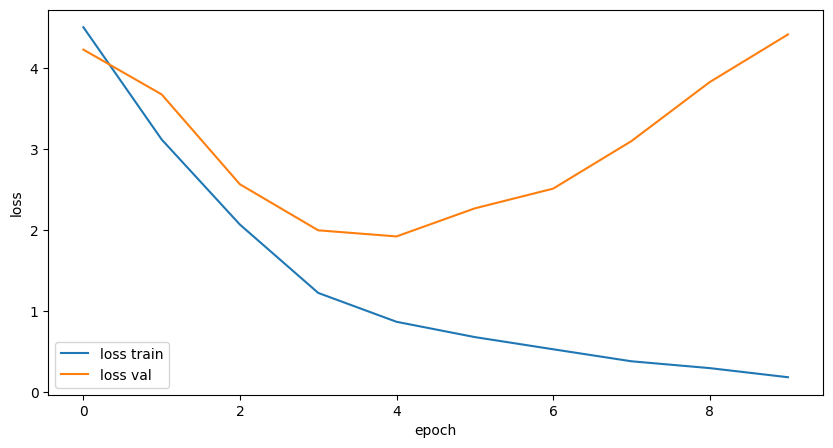

In [77]:
# pickle load, do with cpu

# fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize=(30, 20))
# axs = axs.flatten()
plt.figure(figsize = (10, 5))
for t in range(epoch_test):
    with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "rb") as f:
        perform = pickle.load(f)

    loss_hist_train = perform["train_loss"]
    loss_hist_test = perform["val_loss"]
    print(loss_hist_test)
    plt.plot(loss_hist_train, label = "loss train")
    plt.plot(loss_hist_test, label = "loss val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    break
plt.show()

###### Training

In [ ]:
gc.collect()
# //////////////////////////////////////////////////
# batch size : define in data section
config = {
    "epoch": 3,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)

####################################################################
# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

# ///////////////////////////////////////////////////////////////
# training
# counts:
# [n of positive, n of negative, n of neutral]
# returns_methods:
# [ret of buy all, ret of buy when pos, ret of buy when neg, ret of buy when neu]
senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods = training_finetune(
  data_train, data_val, senti_finbert, optimizer, scheduler, config)
####################################################################

####################################################################
# store, in val do not need. store in test section
# store for gpu
"""
file_name = f"finetune({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.state_dict(), model_path)

# store for cpu
file_name = f"finetune({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(senti_finbert.to("cpu").state_dict(), model_path)
"""
####################################################################


####################################################################
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["test_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "wb") as f:
  pickle.dump(perform, f)
####################################################################


# load model/result
"""
file_name = "fintune(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/Sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}test{t}.pickle", "rb") as f:
    d = pickle.load(f)

###### Plot

In [ ]:
# pickle load, do with cpu
import matplotlib.ticker as ticker
plt.figure(figsize = (10, 10))
plt.plot(loss_hist_train, label = "loss train")
plt.plot(loss_hist_test, label = "loss test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

###### Check Backtest

In [ ]:
# Backtest in train_finetune function
# perform["returns_methods"]: Epoch 1, Epoch 2, Epoch3, ...
# [holding returns, buy when positive, neutral, negative]
perform["returns_methods"]

##### === Model add layer ===

###### Backtest Function

In [108]:
def backtest(test_result, upper, lower):
    output, returns, loss = test_result
    count_positive = 0
    count_negative = 0
    count_neutral = 0
    positive = torch.tensor([0.])
    negative = torch.tensor([0.])
    neutral = torch.tensor([0.])
    state = ""
    for (o_, r_) in zip(output, returns):
        if o_ >= upper:
            count_positive += 1
            positive += (r_ - 0.004) if state != "positive" else r_
            state = "positive"
        elif o_ <= lower:
            count_negative += 1
            negative += (r_ - 0.004) if state != "negative" else r_
            state = "negative"
        else:
            count_neutral += 1
            neutral += (r_ - 0.004) if state != "neutral" else r_
            state = "neutral"
    """
    print(f"N positive: {count_positive}; N neutral: {count_neutral}; N negative: {count_negative}")
    print(f"buy with predicted return >= 0.004: {positive}")
    print(f"buy with predicted return between +(-)0.004: {neutral}")
    print(f"buy with predicted return <= -0.004: {negative}")
    """
    returns_method = [np.array(returns.sum().reshape(1))[0], np.array(positive.reshape(1))[0],
                      np.array(neutral.reshape(1))[0], np.array(negative.reshape(1))[0]]
    counts = [count_positive, count_neutral, count_negative]
    return returns_method, counts

###### Model

In [109]:
# from Eng to tokens
# seperate whole tokens by 512, the limit of transformers, and add the result together for each part
# compute loss with labels, eg: tensor([1]), tensor([[ 6.0247, -8.2679, -4.6360]], grad_fn=<AddBackward0>)
# confirm working and training ok. while sometimes it won't train don't know why. maybe is lr??? to figure out
class Net(torch.nn.Module):

    def __init__(self, senti_finbert): # input_ids.shape[1]# , hd_size
        super(Net, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.linear_tobert = torch.nn.Linear(20, 512).to(device)
        # self.activation = torch.nn.functional.relu
        # self.norm1 = torch.nn.BatchNorm1d(in_size).to(device)
        self.linear2returns = torch.nn.Linear(3, 1).to(self.device)
        self.senti_finbert = senti_finbert

    def forward(self, input_ids, token_type_ids, attention_mask):
        x = self.senti_finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        x = self.linear2returns(x[0])
        return x

###### Train and Test Function

In [110]:
def training_addlayer(data_train, data_test, senti_finbert, optimizer, scheduler, lossf, config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    returns_methods = []
    counts = []
    loss_hist_train = []
    loss_hist_test = []
    for epoch in range(config["epoch"]):
        loss_sum = 0
        for index, batch in enumerate(data_train):
            # if index // 10 == 0:
            #     print("batch in epoch:", index)
            input_ids = batch[0].to(device)
            token_type_ids = batch[1].to(device)
            attention_mask = batch[2].to(device)
            ret_labels = batch[3].to(device)
            ret_num = batch[4].to(device)
            output = senti_finbert(input_ids, # add layer senti_finbert
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask)
            loss = lossf(output.to(torch.float32), ret_num.to(torch.float32))
            loss_sum += loss.detach().cpu()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.) # do this? prevent from gradient explode or deminish
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        print(f"training loss EPOCH {epoch}: {loss_sum/(index + 1)}" )
        # test
        output_test, returns_test, test_loss = testing_addlayer(data_test, senti_finbert, lossf)
        test_results = (output_test, returns_test, test_loss)
        # backtest
        output_train, returns_train, loss = testing_addlayer(data_train, senti_finbert, lossf)
        lower, upper = np.percentile(np.array(output_train), 20), np.percentile(np.array(output_train), 80)
        returns_method, counts_period = backtest(test_results, upper, lower)

        loss_hist_train.append(loss_sum/(index + 1))
        loss_hist_test.append(test_loss)
        returns_methods.append(returns_method)
        counts.append(counts_period)
    return senti_finbert, loss_hist_train, loss_hist_test, counts, returns_methods

def testing_addlayer(data_test, FT_senti_finbert, lossf):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_test = torch.empty((0, 1))
    returns_test = torch.empty((0, 1))
    loss_sum = 0
    for index, batch in enumerate(data_test):
        # if index // 5 == 0:
        #     print("batch in epoch:", index)
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        ret_labels = batch[3].to(device)
        ret_num = batch[4].to(device)
        output = FT_senti_finbert(input_ids,
                        token_type_ids = token_type_ids,
                        attention_mask = attention_mask)
        loss = lossf(output.to(torch.float32), ret_num.to(torch.float32))
        loss_sum += loss.detach().cpu()
        output_test = torch.cat((output_test, output.detach().cpu()))
        returns_test = torch.cat((returns_test, ret_num.cpu()))
    print(f"test loss: {loss_sum/(index + 1)}")
    return output_test, returns_test, loss_sum/(index + 1)

###### Validation

In [ ]:
# ////////////////////////////////////////////////////////////
# Add layer
gc.collect()
config = {
    "epoch": 20,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)
# ////////////////////////////////////////////////////////////

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
# if want to load the finetuned bert to  add layer and train again run below
"""
file_name = "finbert_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/Sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(mdoel_path))
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(senti_finbert)
optimizer = AdamW(model.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)
lossf = torch.nn.MSELoss()

# training
model, loss_hist_train, loss_hist_test, counts, returns_methods = training_addlayer(
    data_train, data_val, model, optimizer, scheduler, lossf, config)

# store
file_name = f"ADDlayer({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.state_dict(), model_path)

file_name = f"ADDlayer({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.to("cpu").state_dict(), model_path)


# load model
"""
file_name = "finbert(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["test_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/addlayer_{smallLR}.pickle", "wb") as f:
    pickle.dump(perform, f)

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}.pickle", "rb") as f:
    d = pickle.load(f)


###### Plot

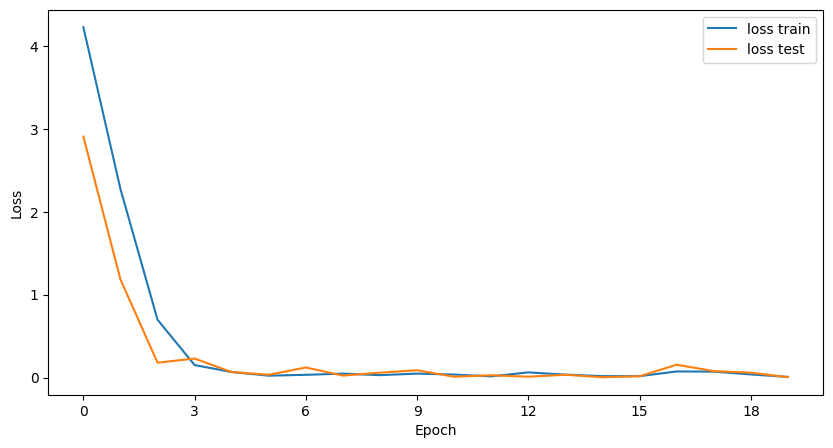

In [115]:
# pickle load, do with cpu
import matplotlib.ticker as ticker
plt.figure(figsize = (10, 5))
plt.plot(loss_hist_train, label = "loss train")
plt.plot(loss_hist_test, label = "loss test")
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

###### Test

In [ ]:
# ////////////////////////////////////////////////////////////
# Add layer
gc.collect()
config = {
    "epoch": 6,
    "smallLR": "smallLR",
    "lr": 0.005,
    "weight_decay": 0.001,
    "num_warmstep": 5000,
          }
smallLR = config["smallLR"]
if smallLR == "smallLR":
    config["lr"] = 0.005/np.ceil(len(merge_train)/batch_size)
# ////////////////////////////////////////////////////////////

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
# if want to load the finetuned bert to  add layer and train again run below
"""
file_name = "finbert_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(mdoel_path))
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(senti_finbert)
optimizer = AdamW(model.parameters(), lr = config["lr"], weight_decay = config["weight_decay"])
total_steps = len(merge_train) * config["epoch"]
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)
lossf = torch.nn.MSELoss()

# training
model, loss_hist_train, loss_hist_test, counts, returns_methods = training_addlayer(
    data_train, data_test, model, optimizer, scheduler, lossf, config)

# store
file_name = f"ADDlayer({smallLR})_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.state_dict(), model_path)

file_name = f"ADDlayer({smallLR},cpu)_友達220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/trained_model/{file_name}'
torch.save(model.to("cpu").state_dict(), model_path)


# load model
"""
file_name = "finbert(cpu)_友達_220728to230428.pth"
model_path = f'/content/drive/MyDrive/sentiment/finetuned_model/{file_name}'
senti_finbert.load_state_dict(torch.load(model_path))
"""
# store result
perform = {}
perform["train_loss"] = loss_hist_train
perform["test_loss"] = loss_hist_test
perform["counts"] = counts
perform["returns_methods"] = returns_methods

with open(f"/content/drive/MyDrive/sentiment/result/addlayer_{smallLR}.pickle", "wb") as f:
    pickle.dump(perform, f)

with open(f"/content/drive/MyDrive/sentiment/result/finetune_{smallLR}.pickle", "rb") as f:
    d = pickle.load(f)


###### Check Backtest

In [119]:
# Backtest in train_finetune function
# perform["returns_methods"]: Epoch 1, Epoch 2, Epoch3, ...
# [holding returns, buy when positive, neutral, negative]
perform["returns_methods"]

[[0.11328314749468767, -0.041862216, 0.10060953, -0.08546415],
 [0.11328314749468767, -0.059097882, 0.08451425, -0.080133244],
 [0.11328314749468767, -0.11575779, 0.0027167457, 0.06632419],
 [0.11328314749468767, -0.018909665, -0.100034885, 0.056227688],
 [0.11328314749468767, -0.04565102, -0.088319786, 0.06725395],
 [0.11328314749468767, -0.032883443, -0.10341147, 0.06557805],
 [0.11328314749468767, 0.025242254, -0.09156776, 0.015608649],
 [0.11328314749468767, -0.11767568, 0.1746059, -0.09964708],
 [0.11328314749468767, -0.008066489, -0.0043840506, -0.018266309],
 [0.11328314749468767, -0.018600872, 0.07097779, -0.09509379],
 [0.11328314749468767, -0.00029575394, -0.10554821, 0.051127102],
 [0.11328314749468767, -0.10001828, 0.046384763, -0.009083344],
 [0.11328314749468767, -0.104223326, 0.06255629, -0.009049829],
 [0.11328314749468767, -0.06586074, 0.004825651, 0.018318243],
 [0.11328314749468767, -0.11767002, 0.04691678, 0.028036386],
 [0.11328314749468767, -0.08310164, 0.09111611

[[0.11328314749468767, -0.041862216, 0.10060953, -0.08546415],
 [0.11328314749468767, -0.059097882, 0.08451425, -0.080133244],
 [0.11328314749468767, -0.11575779, 0.0027167457, 0.06632419],
 [0.11328314749468767, -0.018909665, -0.100034885, 0.056227688],
 [0.11328314749468767, -0.04565102, -0.088319786, 0.06725395],
 [0.11328314749468767, -0.032883443, -0.10341147, 0.06557805],
 [0.11328314749468767, 0.025242254, -0.09156776, 0.015608649],
 [0.11328314749468767, -0.11767568, 0.1746059, -0.09964708],
 [0.11328314749468767, -0.008066489, -0.0043840506, -0.018266309],
 [0.11328314749468767, -0.018600872, 0.07097779, -0.09509379],
 [0.11328314749468767, -0.00029575394, -0.10554821, 0.051127102],
 [0.11328314749468767, -0.10001828, 0.046384763, -0.009083344],
 [0.11328314749468767, -0.104223326, 0.06255629, -0.009049829],
 [0.11328314749468767, -0.06586074, 0.004825651, 0.018318243],
 [0.11328314749468767, -0.11767002, 0.04691678, 0.028036386],
 [0.11328314749468767, -0.08310164, 0.09111611

# LSTM-FINBERT

### Data

In [ ]:
def get_tokenizers(data_merge):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # get tokenizer for input_ids, token_type_ids, att_masks
    ret_num = torch.tensor(np.array(data_merge["return"])).reshape(-1, 1)
    ret_labels = torch.where(ret_num > 0.005, torch.tensor(1), torch.where(ret_num < -0.005, torch.tensor(2), torch.tensor(0)))
    senti_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    tokens = senti_tokenizer(data_merge["shorten_text"].to_list(), return_tensors="pt",
                              max_length=1024,
                              padding = True, truncation=True).to(device) # 0:index, 1:time, 2:title, 3:text

    input_ids = tokens["input_ids"] # 0
    token_type_ids = tokens["token_type_ids"] # 1
    att_masks = tokens["attention_mask"] # 2
    return input_ids, token_type_ids, att_masks, ret_num, ret_labels

def get_dataloader(data_df, returns, batch_size = 1):
    # padding and dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_merge = pd.merge(data_df, returns, on = "time", how = "left")
    input_ids, token_type_ids, att_masks, ret_num, ret_labels = get_tokenizers(data_merge)
    # print(input_ids.shape, ret_num.shape, token_type_ids.shape, att_masks.shape)

    data = TensorDataset(
        input_ids.to(device),
        token_type_ids.to(device),
        att_masks.to(device),
        ret_labels.to(device),
        ret_num.to(device))

    # Create the DataLoader for our training set.
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    """
    print([i.shape[1] for i in input_ids])
    print([i.shape[1] for i in token_type_ids])
    print([i.shape[1] for i in att_masks])
    """
    return dataloader

# get data from words to tokenized dataloader
path = f"/content/drive/MyDrive/Sentiment/shortened_text/shortened_{media}_{keyword}.pickle"
data_all = pickle_load(path)

# train test split
data_train = data_all[(data_all["time"] >= from_date) & (data_all["time"] <= end_date)]
return_train = returns[(returns["time"] >= from_date) & (returns["time"] <= end_date)]
data_test = data_all[(data_all["time"] >= val_from_date) & (data_all["time"] <= val_end_date)]
return_test = returns[(returns["time"] >= val_from_date) & (returns["time"] <= val_end_date)]
batch_size = 1
data_train = get_dataloader(data_train, returns, batch_size = 5)
data_test = get_dataloader(data_test, returns, batch_size = 1)

### Model

In [ ]:
hidden = (torch.randn(1, 2, 3),
          torch.randn(1, , 3))
hidden[1].shape

torch.Size([1, 1, 3])

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
lstm = nn.LSTM(3, 3)  # 输入维度为3维，输出维度为3维
lstm = nn.LSTM(3, 42, 5, batch_first=True)
inputs = [torch.randn(6, 3) for _ in range(5)]  # 生成一个长度为5的序列

# 初始化隐藏状态.
hidden = (torch.randn(5, 1, 42),
          torch.randn(5, 1, 42))
for i in inputs:
    # 将序列中的元素逐个输入到LSTM.
    # 经过每步操作,hidden 的值包含了隐藏状态的信息.
    print(i.view(1, i.shape[0], i.shape[1]).shape)
    out, hidden = lstm(i.view(1, i.shape[0], i.shape[1]), hidden)
    print(out.shape)
    print(hidden[0].shape)
    break

torch.Size([1, 6, 3])
torch.Size([1, 6, 42])
torch.Size([5, 1, 42])


In [ ]:
gc.collect()

4179

In [ ]:
import torch.nn as nn
class lstm(nn.Module):
    def __init__(self, senti_finbert, input_size, hidden_size, num_layers, output_size):
        super(lstm, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.finbert = senti_finbert

    def forward(self, input_ids, token_type_ids, attention_mask):
        x = self.finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        h0 = torch.zeros(self.num_layers, input_ids.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input_ids.shape[0], self.hidden_size).to(device)
        out, _ = self.lstm(x[0].view(1, x[0].shape[0], x[0].shape[1]), (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)

input_size = 3
hidden_size = 6
num_layers = 3
output_size = 1
model = lstm(senti_finbert, input_size, hidden_size, num_layers, output_size)
for i, batch in enumerate(data_train):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = batch[0].to(device)
    token_type_ids = batch[1].to(device)
    attention_mask = batch[2].to(device)
    ret_labels = batch[3].to(device)
    ret_num = batch[4].to(device)
    out = model(input_ids, token_type_ids, attention_mask)
    print(out)
    break

In [ ]:
a[0]

tensor([[ 5.0697, -4.7721, -2.7422],
        [ 0.8556,  0.1799, -4.1545],
        [ 0.1794, -3.2106,  4.0470],
        [-2.0179, -3.3628,  5.3450],
        [ 6.5229, -4.9477, -3.7289]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch.nn as nn
class lstm(nn.Module):
    def __init__(self, senti_finbert, input_size, hidden_size, num_layers, output_size):
        super(lstm, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.finbert = senti_finbert

    def forward(self, x):
        x = self.finbert(input_ids,
                              token_type_ids = token_type_ids,
                              attention_mask = attention_mask)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size =  input_dimension  # Size of input features
hidden_size = lstm_hidden_size  # Number of LSTM units (hidden states)
num_layers = lstm_num_layers   # Number of LSTM layers
output_size = num_classes      # Number of classes for classification

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in dataloader:  # Iterate through your dataset
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
This is a basic outline of how to create an LSTM model using PyTorch's torch.nn.LSTM module. Remember to replace placeholders like input_dimension, lstm_hidden_size, lstm_num_layers, num_classes, learning_rate, and implement your own data loading pipeline using dataloader.







SyntaxError: ignored

In [ ]:
output, returns = backtest_finbert(data_test, finetune = True)
def backtesting(data_test, FT_senti_finbert, type_): # type: [finetune, add_layer]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    output_test = torch.empty((0, 3)) if type_ == "finetune" else  torch.empty((0, 1))
    returns_test = torch.empty((0, 1))
    loss_sum = 0
    for index, batch in enumerate(data_test):
        # if index // 5 == 0:
        #     print("batch in epoch:", index)
        input_ids = batch[0].to(device)
        token_type_ids = batch[1].to(device)
        attention_mask = batch[2].to(device)
        ret_labels = batch[3].to(device)
        ret_num = batch[4].to(device)
        if type_ == "finetune":
            output = FT_senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask,
                            labels = ret_labels.long())
            output = output[1]
        if type_ == "add_layer":
            output = FT_senti_finbert(input_ids,
                            token_type_ids = token_type_ids,
                            attention_mask = attention_mask)
        output_test = torch.cat((output_test, output.detach().cpu()))
        returns_test = torch.cat((returns_test, ret_num.cpu()))
    return output_test, returns_test, loss_sum/(index + 1)

In [ ]:
#### Not shorten func (newest)
def get_tokenizers(data_df, returns, device):
    # get tokenizer for input_ids, token_type_ids, att_masks
    senti_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    input_ids = []
    token_type_ids = []
    att_masks = []
    labels = []
    returns_num = []
    crossdate_text = ""
    state = "continuous"
    for index, i in data_df.reset_index().iterrows():
        print(i[1])
        tokens = senti_tokenizer(i[3], return_tensors="pt",
                                 max_length=max([len(l) for l in data_df["text"]]),
                                 padding = True, truncation=True).to(device) # 0:index, 1:time, 2:title, 3:text

        input_ids.append(tokens["input_ids"]) # 0
        token_type_ids.append(tokens["token_type_ids"]) # 1
        att_masks.append(tokens["attention_mask"]) # 2
        if returns["return"][returns["time"] == i[1]].values >= 0.005: # pos
            returns_label = torch.tensor(1)
        elif returns["return"][returns["time"] == i[1]].values <= -0.005: # neg
            returns_label = torch.tensor(2)
        else: # neu
            returns_label = torch.tensor(0)
        labels.append(returns_label)
        returns_num.append(torch.tensor(returns["return"][returns["time"] == i[1]].values))
    return input_ids, token_type_ids, att_masks, labels, returns_num

def get_dataloader(data_df, returns, from_date, end_date, path, batch_size = 1):
    # padding and dataloader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_df = data_df[(data_df["time"] >= from_date) & (data_df['time'] <= end_date)]
    input_ids, token_type_ids, att_masks, labels, returns_num = get_tokenizers(data_df, returns, device)
    max_inputs = max([i.shape[1] for i in input_ids])
    max_tokens = max([i.shape[1] for i in token_type_ids])
    max_atts = max([i.shape[1] for i in att_masks])
    input_ids = [torch.nn.functional.pad(i, (0,max_inputs - i.shape[1])) for i in input_ids]
    token_type_ids = [torch.nn.functional.pad(i, (0, max_tokens - i.shape[1])) for i in token_type_ids]
    att_masks = [torch.nn.functional.pad(i, (0, max_atts - i.shape[1])) for i in att_masks]
    # print(torch.stack(input_ids).squeeze(1).to(device), token_type_ids, att_masks)

    data = TensorDataset(
        torch.stack(input_ids).squeeze(1).to(device),
        torch.stack(token_type_ids).squeeze(1).to(device),
        torch.stack(att_masks).squeeze(1).to(device),
        torch.stack(labels).to(device),
        torch.stack(returns_num).to(device))

    # Create the DataLoader for our training set.
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)
    """
    print([i.shape[1] for i in input_ids])
    print([i.shape[1] for i in token_type_ids])
    print([i.shape[1] for i in att_masks])
    """
    return dataloader

# from Eng to tokens
# seperate whole tokens by 512, the limit of transformers, and add the result together for each part
# compute loss with labels, eg: tensor([1]), tensor([[ 6.0247, -8.2679, -4.6360]], grad_fn=<AddBackward0>)
# confirm working and training ok. while sometimes it won't train don't know why. maybe is lr??? to figure out
class Net(torch.nn.Module):

    def __init__(self, in_size): # input_ids.shape[1]# , hd_size
        super(Net, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.linear_tobert = torch.nn.Linear(in_size, 512).to(device)
        self.activation = torch.nn.functional.relu
        self.norm1 = torch.nn.BatchNorm1d(in_size).to(device)

    def forward(self, input_ids, token_type_ids, attention_masks, labels):
        # positional encoding?
        scores =  torch.zeros([input_ids.shape[0], 3], dtype = torch.float32).to(device)
        for k, i in enumerate(range(input_ids.shape[1]//512)):
            part_input_ids = input_ids[:, i*512:(i+1)*512]
            part_token_type_ids = token_type_ids[:, i*512:(i+1)*512]
            part_att_masks = attention_masks[:, i*512:(i+1)*512]
            # print(part_input_ids, part_token_type_ids, part_att_masks)
            x = senti_finbert(part_input_ids,
                              token_type_ids = part_token_type_ids,
                              attention_mask = part_att_masks)
            scores += x[0]
            if k >= 2:
                break
        return scores

In [ ]:
# working codes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_d"])
epoch = config["epoch"]
total_steps = len(data) * epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

for i in range(epoch):
    loss = 0
    for index, batch in enumerate(data):
        gc.collect()
        for i in range(input_ids.shape[1]//512)
        input_ids = torch.tensor(batch[0][:, :512]).to(device) # , dtype = torch.float32
        token_type_ids = torch.tensor(batch[1][:, :512]).to(device)
        att_masks = torch.tensor(batch[2][:, :512]).to(device)
        labels = torch.tensor(batch[3]).to(device)
        returns_num = batch[4].to(device)
        output = senti_finbert(input_ids,
                                     token_type_ids = token_type_ids,
                                     attention_mask = att_masks,
                                     labels = labels.long())
        print(labels, output)
        loss = output[0]
        loss.backward()
        # clip_grad_norm_(senti_finbert.parameters(), 1.)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        loss += loss
    print(loss)


"""
        input_ids = torch.tensor(self.linear_tobert(torch.tensor(input_ids, dtype = torch.float32)), dtype =  torch.int).to(device) # , dtype = torch.float32
        token_type_ids = torch.tensor(self.linear_tobert(torch.tensor(token_type_ids, dtype = torch.float32)), dtype =  torch.int).to(device)
        attention_mask = torch.tensor(self.linear_tobert(torch.tensor(attention_mask, dtype = torch.float32)), dtype =  torch.int).to(device)
"""

In [ ]:
config = {
    "epcoh": 10,
    "lr": 1,
    "weight_d": 0.00,
    "num_warmstep": 5000, # 10000
          }
senti_finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
optimizer = AdamW(senti_finbert.parameters(), lr = config["lr"], weight_decay = config["weight_d"])
epoch = config["epcoh"]
total_steps = len(data) * epoch
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = config["num_warmstep"], num_training_steps = total_steps)

for i in range(epoch):
    for index, batch in enumerate(data):
        b_input_id = batch[0][:, :512].to(device)
        b_token_type_id = batch[1][:, :512].to(device)
        b_att_mask = batch[2][:, :512].to(device)
        b_labels = batch[3].to(device)
        # senti_finbert.zero_grad()
        output = senti_finbert(input_ids = b_input_id, token_type_ids = b_token_type_id, attention_mask = b_att_mask, labels = b_labels)
        loss, logits = output[0], output[1]
        loss.backward()
        clip_grad_norm_(senti_finbert.parameters(), 1.)
        optimizer.step()
        scheduler.step()
        print(logits)
        #print(b_input_id.shape)
        #print(b_token_type_id.shape)
        #print(b_att_mask.shape)
        #print(b_labels.shape)

"""
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]
"""

tensor([[ 1.4937, -2.6720, -0.6041],
        [ 7.3032, -3.0453, -6.8335],
        [ 4.5546, -0.7754, -6.1829],
        [-0.8579, -2.5491,  4.7933]], grad_fn=<AddmmBackward0>)
tensor([[ 1.4937, -2.6720, -0.6041],
        [ 7.3032, -3.0453, -6.8335],
        [ 4.5546, -0.7754, -6.1829],
        [-0.8579, -2.5491,  4.7933]], grad_fn=<AddmmBackward0>)


KeyboardInterrupt: ignored